## CIFAR 10

The first steps are to create a custom fully connected neural network. Producing an accuracy of about 47%, we move on to the Convolutional NN.

#### Fully Connected Network:
- In each layer, the inputs are all matrix multiplied (sum dot product) with all the weights.
- Using this network as an example, the first layer has 3072 input params (the 32x32x3 input imgage) and 40 values of output features (weights). For a total of 3072 * 40 = 122880. This basically means that every single input image pixel has its own weight.

#### Fully Convolutional Neural Network (except the last layer)
- A Fully Convolutional Neural Network does a convolution in each layer, usually with a stride of 2.
- We're going a convolution on the 32x32x3 image with many 3x3 weight matrices which produces interesting patterns that the NN learns.
- The group of 3x3 kernels for each layer is called a multi dimensional tensor.
- After the convolutions in that layer, we can optionally use maxpool(old style) to reduce the resolution of the input has it moves through the different layers of the network OR a convolution with stide=2 (state of the art)
- Mathmatically, the 3x3 convolution is a sum dot product
- the last step of a CNN needs convert the image in to 1 of x classification categories. We do this with adaptive maxpooling which specifies the output size. Use nn.AdaptiveMaxPool2d(1) to be 1x1
- This code uses the nn.AdaptiveMaxPool2d class and saves it in the init. Howerver, we could have used the function version. F.adaptive_max_pool
- x = x.view(x.size(0), -1) This line in the ConvNet Class gits rid of the trailing 1,1 axis "images" in the final linear layer which were created by the output of the AdaptiveMaxPool2d.

#### Refactored CNN
- Add padding=1 which will add 0s around the edge which enables the first convolutions to be centered around row1, col1.
    - WAS: 32x32 -> 15x15 -> 7x7
    - NOW: 32x32 -> 16x16 -> 8x8
- 

In [26]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [27]:
## Import up sound alert dependencies
from IPython.display import Audio, display

In [28]:
def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

I did the line below in terminal to get an idea of what classes of images we have (10 total).
cd train && find . | grep -o [a-z]*.png | sort -u && cd .

In [29]:
from fastai.conv_learner import *
PATH = "data/cifar/"
os.makedirs(PATH,exist_ok=True)

In [30]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#since we're not using pre-trained model, must pass in mean and std dev
# I should write the code to do this myself as a HW assignment
#                  mean                                       std. dev.
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [31]:
def get_data(sz,bs):
    #aug_tfms = data transformation
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlipXY()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [32]:
bs=256

### Look at data

In [33]:
data = get_data(32,4)

In [34]:
x,y=next(iter(data.trn_dl))

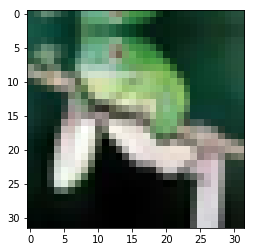

In [35]:
plt.imshow(data.trn_ds.denorm(x)[0]);

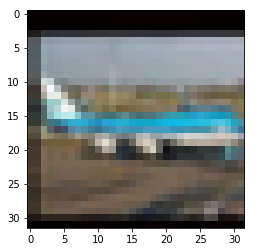

In [36]:
plt.imshow(data.trn_ds.denorm(x)[3]);

## Fully connected model

In [37]:
data = get_data(32,bs)

In [38]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [39]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        #Below, the list of fully connected layers
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        # flatten the data that comes in since it's in a fully connected layer
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x) #apply ReLU to self
        return F.log_softmax(l_x, dim=-1)

In [40]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [41]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40)
     (1): Linear(in_features=40, out_features=10)
   )
 ), [122880, 40, 400, 10])

In [42]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [43]:
learn.lr_find(); allDone()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▌  | 149/196 [00:15<00:04,  9.75it/s, loss=20.5]

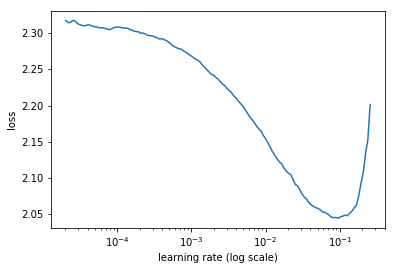

In [44]:
learn.sched.plot()

In [45]:
%time learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 17%|█▋        | 33/196 [00:03<00:19,  8.44it/s, loss=2.05]

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       1.76122  1.65535  0.4165 ]                       
[ 1.       1.68377  1.56238  0.44688]                       

CPU times: user 40.7 s, sys: 39.1 s, total: 1min 19s
Wall time: 48.3 s


In [47]:
%time learn.fit(1e-2, 2); allDone()

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.65622  1.52727  0.46436]                       
[ 1.       1.62335  1.50718  0.47012]                       



CPU times: user 40.9 s, sys: 38 s, total: 1min 18s
Wall time: 48 s


## CNN

In [48]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [49]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [50]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [51]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|███████   | 138/196 [00:15<00:06,  8.78it/s, loss=130] 

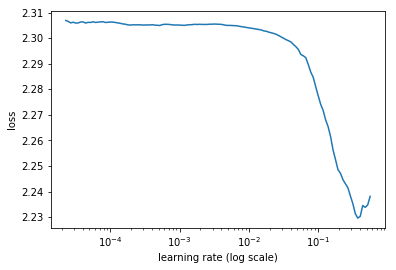

In [52]:
learn.sched.plot()

In [53]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  5%|▍         | 9/196 [00:01<00:24,  7.71it/s, loss=2.3]

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       1.6952   1.53704  0.44932]                       
[ 1.       1.49634  1.42627  0.48281]                       

CPU times: user 40.1 s, sys: 35.2 s, total: 1min 15s
Wall time: 46 s


In [55]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.19463  1.11549  0.60322]                       
[ 1.       1.16208  1.09894  0.6123 ]                       
[ 2.       1.14267  1.08751  0.6209 ]                       
[ 3.       1.14711  1.07544  0.62285]                       

CPU times: user 1min 21s, sys: 1min 12s, total: 2min 34s
Wall time: 1min 33s


## Refactored

In [56]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [57]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [58]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [59]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [60]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 71%|███████   | 139/196 [00:15<00:06,  8.93it/s, loss=95.6]

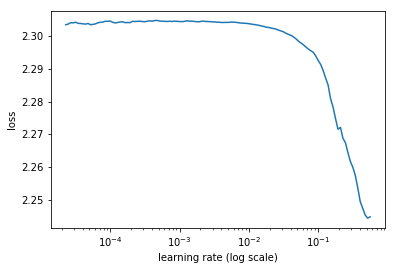

In [61]:
learn.sched.plot()

In [62]:
%time learn.fit(1e-1, 2); allDone()

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  5%|▍         | 9/196 [00:01<00:24,  7.56it/s, loss=2.3]

Exception in thread Thread-26:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       1.69549  1.62429  0.41514]                       
[ 1.       1.48725  1.38398  0.50088]                       



CPU times: user 42.1 s, sys: 38.9 s, total: 1min 21s
Wall time: 49.2 s


In [63]:
%time learn.fit(1e-1, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.35152  1.24752  0.55088]                       
[ 1.       1.28671  1.18516  0.57315]                       

CPU times: user 40.8 s, sys: 36.2 s, total: 1min 16s
Wall time: 46.8 s


## BatchNorm

In [69]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        #nn.Parameter tells allow pytorch to LEARN them as weights:
        self.a = nn.Parameter(torch.zeros(nf,1,1)) #addition for first layer
        self.m = nn.Parameter(torch.ones(nf,1,1)) #multiplier for first layer
        
    def forward(self, x):
        x = F.relu(self.conv(x)) # nested function call to do conv then relu
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        
        if self.training: #true for training, false for validation set
            #Real version of mean/std dev is the exponentially weighted moving avg of each
            self.means = x_chan.mean(1)[:,None,None] # mean of each filter
            self.stds  = x_chan.std (1)[:,None,None] # std dev of each filter
        
        #subtract mean and devide by std dev
        return (x-self.means) / self.stds *self.m + self.a

In [70]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [71]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [72]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [68]:
%time learn.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.45688  1.33776  0.52891]                       
[ 1.       1.23586  1.16343  0.57783]                       

CPU times: user 43.9 s, sys: 37.6 s, total: 1min 21s
Wall time: 49.1 s


In [77]:
%time learn.fit(1e-1, 4, cycle_len=1); allDone()

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.49954  1.35232  0.50674]                       
[ 1.       1.29964  1.15862  0.57871]                       
[ 2.       1.15141  1.04652  0.62891]                       
[ 3.       1.03842  0.95553  0.66055]                       



CPU times: user 1min 50s, sys: 1min 23s, total: 3min 14s
Wall time: 1min 58s


## Deep BatchNorm

In [73]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        #Adding this single 5x5 conv to beginning of the neural net
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        
        #create a stride 1 layer
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        #crate a stride 2 layer for every layer above
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
        #twice as deep as above conv net, but same 2x2 in last layer's output
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2): #combine layers
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [74]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [75]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.50328  1.36383  0.50156]                       
[ 1.       1.26326  1.16499  0.5835 ]                       

CPU times: user 49 s, sys: 39.7 s, total: 1min 28s
Wall time: 53.8 s


In [76]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.07812  0.98841  0.64551]                       
[ 1.       1.00278  0.93057  0.66836]                       



CPU times: user 48.2 s, sys: 39.6 s, total: 1min 27s
Wall time: 53.3 s


## Resnet

In [78]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [79]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [80]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [81]:
wd=1e-5

In [82]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.55236  1.40829  0.48975]                       
[ 1.       1.30356  1.16902  0.58301]                       



CPU times: user 1min 2s, sys: 45.7 s, total: 1min 48s
Wall time: 1min 7s


In [83]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       1.10669  1.02614  0.63594]                       
[ 1.       1.07326  1.00445  0.64551]                       
[ 2.       0.94036  0.90425  0.67598]                        
[ 3.       0.99402  0.95662  0.65791]                        
[ 4.       0.88648  0.86364  0.69316]                        
[ 5.       0.80331  0.79753  0.71875]                        
[ 6.       0.76173  0.76619  0.72988]                        

CPU times: user 3min 55s, sys: 2min 43s, total: 6min 39s
Wall time: 4min 8s


In [84]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

[ 0.       0.8629   0.86541  0.69707]                        
[ 1.       0.77614  0.79168  0.7294 ]                        
[ 2.       0.69146  0.73988  0.74082]                        
[ 3.       0.64577  0.69867  0.76035]                        
[ 4.       0.76085  0.74798  0.74268]                        
[ 5.       0.68997  0.73775  0.74834]                        
[ 6.       0.60701  0.6944   0.76152]                        
[ 7.       0.57247  0.64398  0.77236]                        
[ 8.       0.68374  0.69473  0.75596]                        
[ 9.       0.61269  0.67986  0.76826]                        
[ 10.        0.53791   0.62641   0.78359]                    
[ 11.        0.50224   0.61192   0.78818]                    
[ 12.        0.61237   0.66516   0.77324]                    
[ 13.        0.56208   0.62663   0.78809]                    
[ 14.        0.48663   0.62996   0.78916]                    
[ 15.        0.45323   0.63839   0.78633]                    
[ 16.   

KeyboardInterrupt: 

In [85]:
allDone()

## Resnet 2

In [88]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [89]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [90]:
wd=1e-6

In [91]:
%time learn.fit(1e-2, 2, wds=wd); allDone()

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 12%|█▏        | 23/196 [00:09<01:08,  2.52it/s, loss=2.55]


Exception in thread Thread-57:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       1.78237  1.58747  0.45937]                       
[ 1.       1.52683  1.31955  0.5292 ]                       



CPU times: user 1min 14s, sys: 49.1 s, total: 2min 3s
Wall time: 1min 17s


In [92]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       1.24073  1.09498  0.60918]                       
[ 1.       1.217    1.10058  0.6083 ]                       
[ 2.       1.0617   0.96549  0.65606]                       
[ 3.       1.11263  1.11534  0.63213]                       
[ 4.       0.97316  1.01091  0.66934]                        
[ 5.       0.88045  0.86094  0.69375]                        
[ 6.       0.8232   0.80357  0.71602]                        

CPU times: user 4min, sys: 2min 43s, total: 6min 43s
Wall time: 4min 16s


In [93]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd); allDone()

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

[ 0.       0.94287  0.86857  0.69912]                        
[ 1.       0.828    0.76837  0.7252 ]                        
[ 2.       0.7365   0.71802  0.74473]                        
[ 3.       0.69792  0.70747  0.75117]                        
[ 4.       0.80626  0.75806  0.73135]                        
[ 5.       0.73284  0.72214  0.74961]                        
[ 6.       0.65282  0.66459  0.76885]                        
[ 7.       0.60865  0.6462   0.77275]                        
[ 8.       0.71383  0.7385   0.7417 ]                        
[ 9.       0.65675  0.63778  0.77676]                        
[ 10.        0.57896   0.6041    0.78545]                    
[ 11.        0.55059   0.59929   0.78984]                    
[ 12.        0.65217   0.69322   0.76719]                    
[ 13.        0.5774    0.62897   0.78672]                    
[ 14.        0.51717   0.62146   0.7916 ]                    
[ 15.        0.49482   0.57396   0.80185]                    
[ 16.   

CPU times: user 18min 7s, sys: 12min 16s, total: 30min 24s
Wall time: 19min 23s


In [94]:
learn.save('tmp3')

In [95]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [96]:
metrics.log_loss(y,preds), accuracy(preds,y)

(0.46633394786201005, 0.83940000000000003)

### End